# MPCOrb

The default data file is stored in ASCII, I'm going to quickly convert this to binary to speed things up.

In [1]:
import numpy as np
import h5py as h5
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
import os.path

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [5]:
mpcorb_data_path = "../catalogues/mpcorb_extended.json"
mpcorb_h5_path = "../catalogues/mpcorb.h5"

In [7]:
REREAD = False

if REREAD or not os.path.isfile(mpcorb_h5_path):
    
    mpcorb_df = pd.read_json(mpcorb_data_path)
    mpcorb_df = mpcorb_df[["H", "G", "Principal_desig", "Epoch",
                           "M", "Peri", "Node", "i", "e", "a"]]
    mpcorb_df.rename(columns={"Principal_desig": "des", "Epoch": "epoch",
                              "M": "mean_anom", "Peri": "arg_peri", "Node": "Omega"},
                     inplace=True)
    mpcorb_df.epoch = mpcorb_df.epoch - 2400000.5
    mpcorb_df.to_hdf(mpcorb_h5_path, mode="w", key="df")
    
else:
    mpcorb_df = pd.read_hdf(mpcorb_h5_path)

KeyboardInterrupt: 

# S3M

In [10]:
s3m_data_path = "../catalogues/s3m_files/"
s3m_h5_path = "../catalogues/s3m.h5"
names_s3m = ['id', 'format', 'q', 'e', 'i', 'Omega', 'argperi', 't_p',
             'H', 't_0', 'INDEX', 'N_PAR', 'MOID', 'COMPCODE']

files_s3m = ['S0', 'S1_00', 'S1_01', 'S1_02', 'S1_03', 'S1_04', 'S1_05',
             'S1_06', 'S1_07', 'S1_08', 'S1_09', 'S1_10', 'S1_11', 'S1_12',
             'S1_13', "SL", "St5", "ST"]

In [43]:
df = pd.read_csv(s3m_data_path + "{}.s3m".format("ST"),
                 comment="!", delim_whitespace=True,
                 header=None, names=names_s3m, skiprows=2)

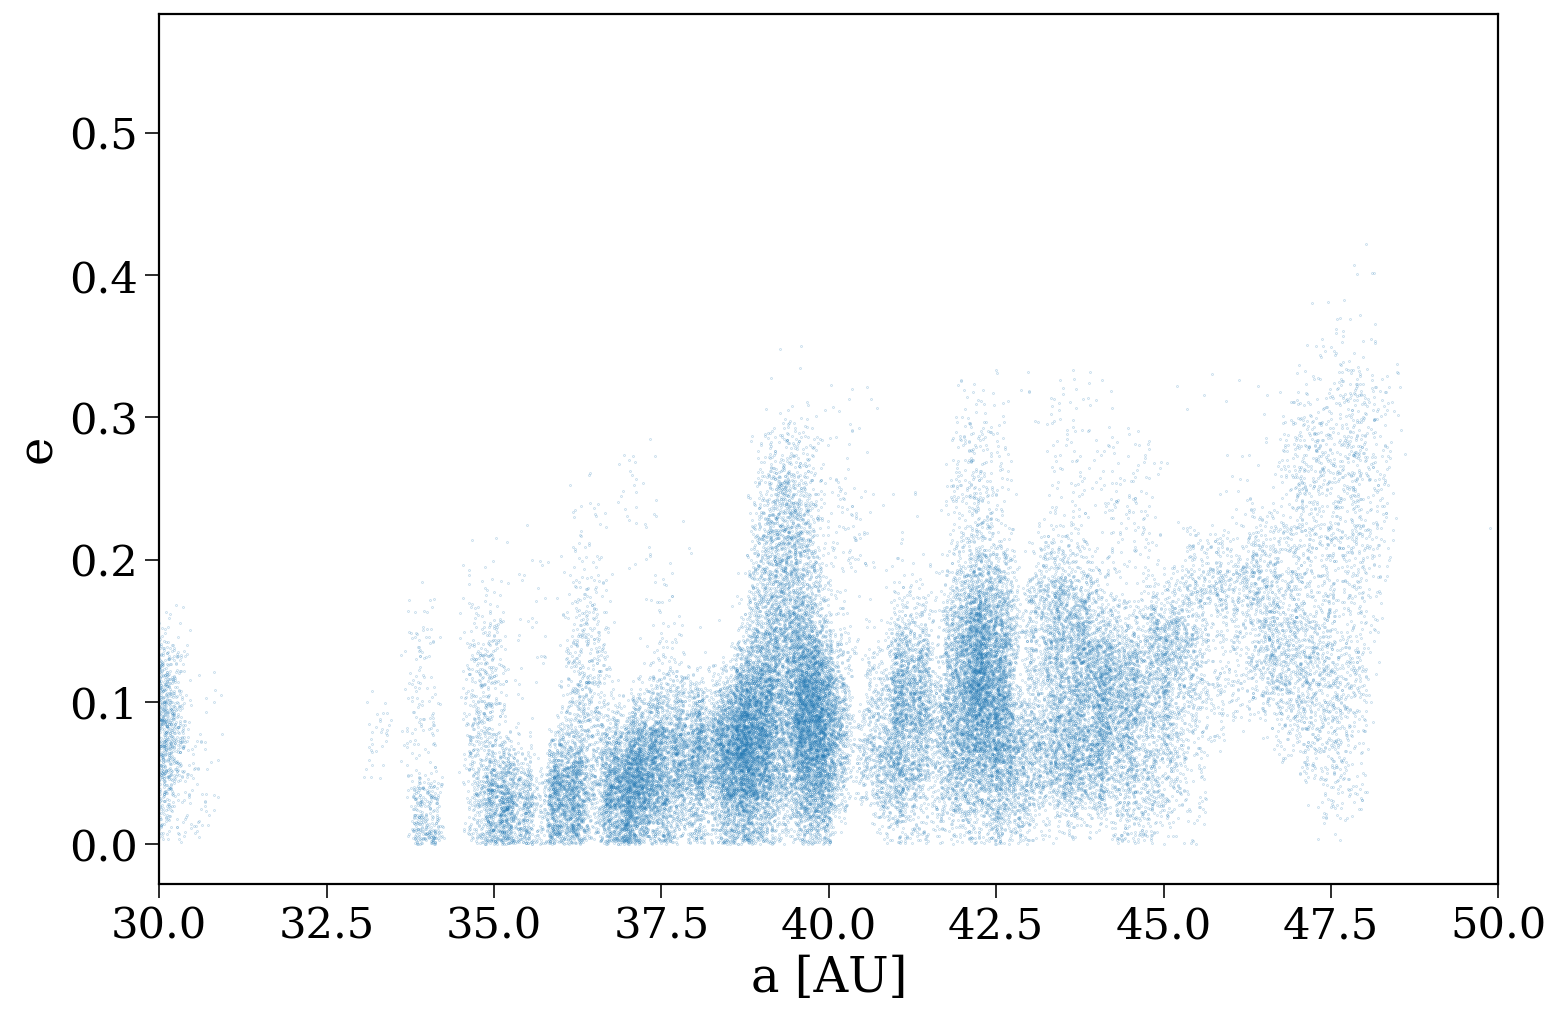

In [45]:
plt.scatter(df.q / (1 - df.e), df.e, s=0.01)
plt.xlim(30, 50)
plt.xlabel("a [AU]")
plt.ylabel("e")
plt.show()

In [31]:
dfs = [None for i in range(len(files_s3m))]

for i in range(len(files_s3m)):
    print(files_s3m[i])
    dfs[i] = pd.read_csv(s3m_data_path + "{}.s3m".format(files_s3m[i]),
                         comment="!", delim_whitespace=True,
                         header=None, names=names_s3m, skiprows=2)

S0
S1_00
S1_01
S1_02
S1_03
S1_04
S1_05
S1_06
S1_07
S1_08
S1_09
S1_10
S1_11
S1_12
S1_13
SL
St5
ST


In [32]:
s3m_df = pd.concat(dfs)

In [33]:
# make sure the indices are unique
s3m_df.set_index("id", inplace=True)

# drop anything with e = 1.0 because openorb can't do it
s3m_df.drop(labels=s3m_df.index[s3m_df.e == 1.0], axis=0, inplace=True)

# save to hdf5
s3m_df.to_hdf(s3m_h5_path, key="df", mode="w")

In [35]:
from astropy.time import Time

In [37]:
Time("2021-12-01").mjd

59549.0

# Some plots for my understanding

## Absolute magnitude histogram

In [251]:
s3m_df.H.max()

26.69

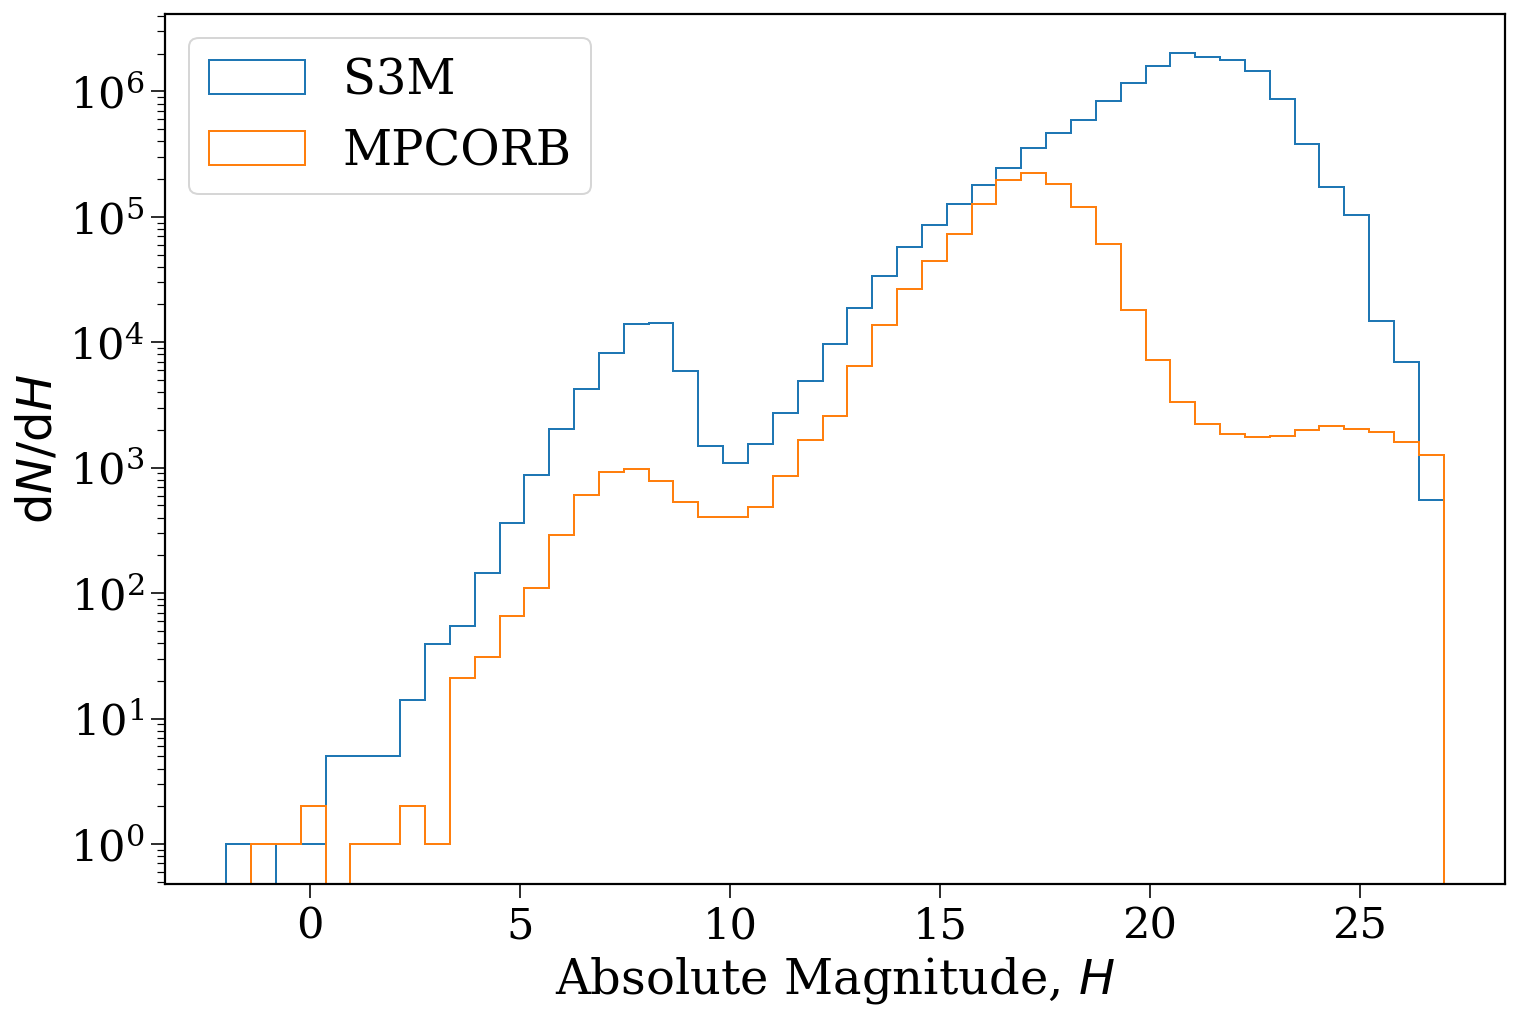

In [319]:
fig, ax = plt.subplots()

bins = np.linspace(-2, 27, 50)

ax.hist(s3m_df.H, bins=bins, histtype="step", label="S3M")
ax.hist(mpcorb_df.H, bins=bins, histtype="step", label="MPCORB")
ax.set_yscale("log")

ax.set_xlabel(r"Absolute Magnitude, $H$")
ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}H$")

ax.legend(loc="upper left")

plt.show()

## $a$ vs $e$

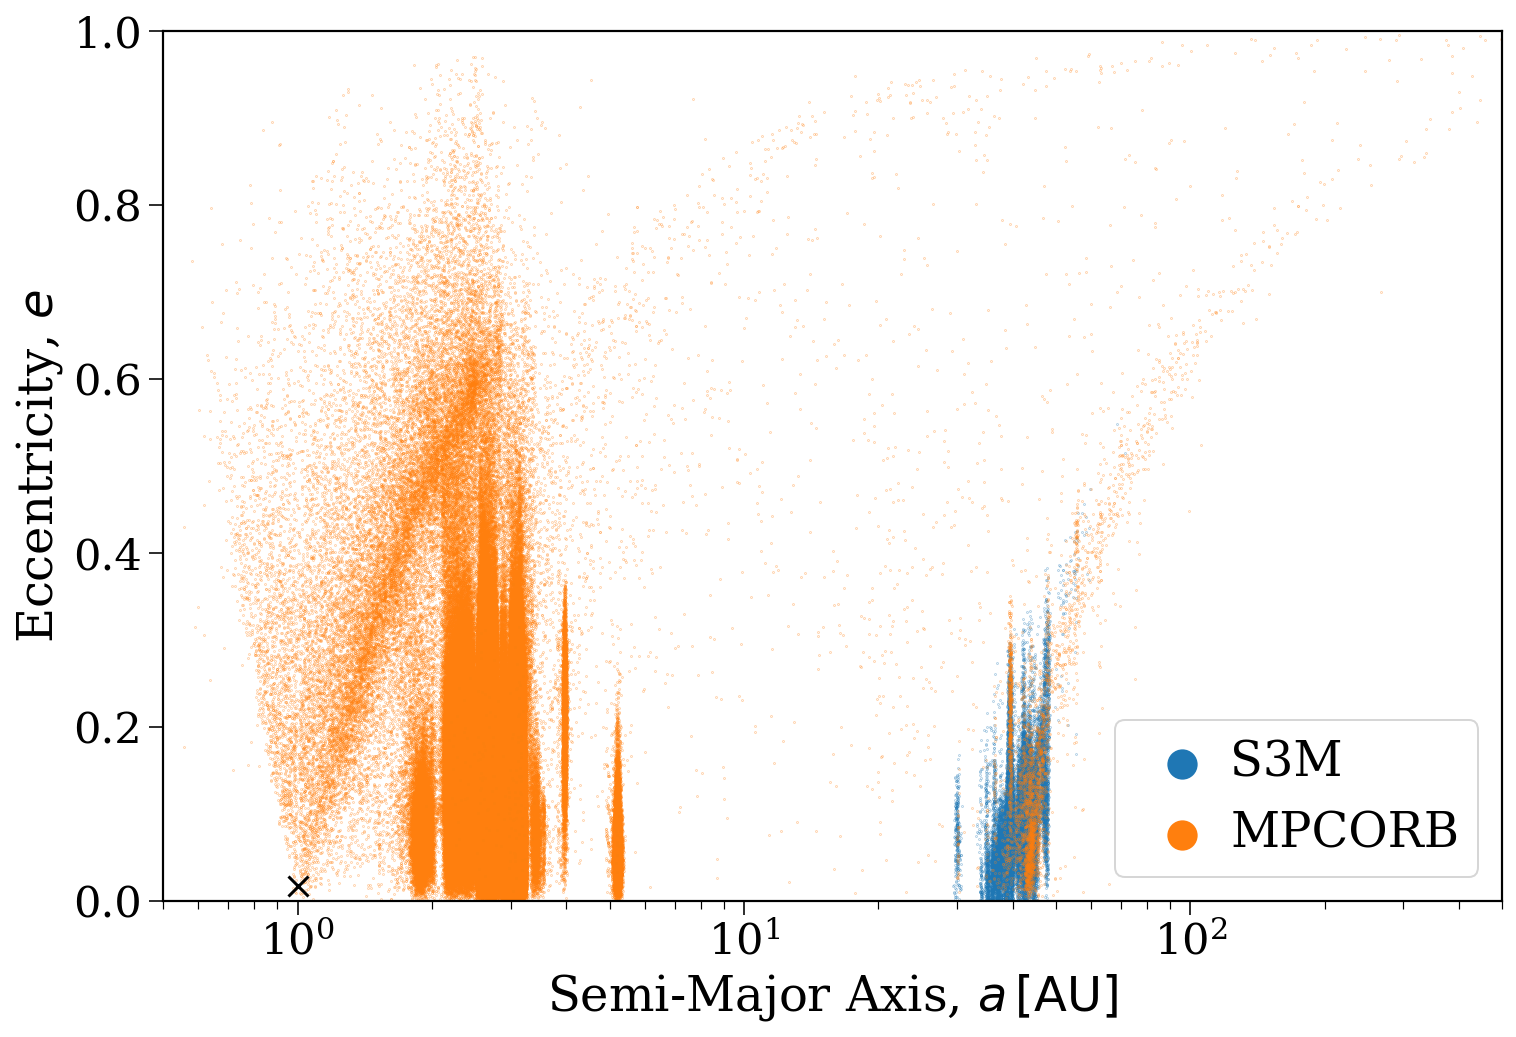

In [237]:
fig, ax = plt.subplots()

the_bump = np.logical_and(s3m_df.H >= 6, s3m_df.H <= 8)

ax.scatter(s3m_df.q[the_bump] / (1 - s3m_df.e[the_bump]), s3m_df.e[the_bump], s=0.02, label="S3M")
ax.scatter(mpcorb_df.a, mpcorb_df.e, s=0.02, label="MPCORB")

ax.scatter(1, 0.01671, s=100, color="black", marker="x")

ax.set_xscale("log")

ax.set_xlim(5e-1, 5e2)
ax.set_ylim(0, 1)

ax.set_xlabel(r"Semi-Major Axis, $a \, [\rm AU]$")
ax.set_ylabel(r"Eccentricity, $e$")

ax.legend(loc="lower right", handletextpad=0.0, markerscale=100)

plt.show()

# Conversion for Ari

In [ ]:
import pandas as pd

n_visits = 204
directories = ['S1_00', 'S1_01', 'S1_02', 'S1_03', 'S1_04', 'S1_05',
               'S1_06', 'S1_07', 'S1_08', 'S1_09', 'S1_10', 'S1_11', 'S1_12',
               'S1_13', "SS", "St5", "ST"]

for directory in directories:
    for i in range(n_visits + 1):
        print(directory, i)
        file = "/epyc/projects/hybrid-sso-catalogs/s3m_for_ari/{}/visit-{}0000.h5".format(directory, str(i).zfill(3))
        df = pd.read_hdf(file)
        df.to_csv(file.replace(".h5", ".csv"))

S1_00 0
S1_00 1
S1_00 2
S1_00 3
S1_00 4
S1_00 5
S1_00 6
